# Personal Information
Name: **Matej Loncaric**

StudentID: **12569372**

Email: [**matej.loncaric@student.uva.nl**](matej.loncaric@student.uva.nl)

Submitted on: **19.03.2023.**

Github: 

# Data Context

The data consists of patiens who underwent pancreatic resection at the Amsterdam UMC between 2013 and 2018. Two types of data are available for each patient:
* The annotated MRI scans, containing the mask of the pancreas and the IPMN
* Clinical variables collected by the Dutch Pancreatic Cancer Group (DPCG).

It is worth noting that doing an exploratory data analysis on patient data is somewhat difficult due to patient confidentiality. Therefore, I will not present any actual scans, but the scan modalities which need to be reported to ensure transparency in the scanning process.

The clinical variables will be added to the hard-coded radiomic features extracted using the PyRadiomics package, as well as deep-learning radiomic features extracted from the second fully connected layer of a convolutional neural network (ResNet50, VGG-19), and will be used to build a binary classifier for preoperative prediction of the development of Postoperative Pancreatic Fistula (POPF) in patients. All radiomic features will be extracted from the mask of the pancreas.
A supplementary data dictionary was provided together with the DPCG data to understand all of the variables. 

# Data Description

## DPCG data

In [1]:
import pandas as pd
import os
import numpy as np
# import seaborn as sns

In [2]:
amc_data = pd.read_csv(r"L:\basic\divi\jstoker\slicer_pdac\Master Students SS 23\Matej\Patient_Data_DPCG\included_patients_DPCG_amc.csv", header = 0, sep = ";")
vumc_data = pd.read_csv(r"L:\basic\divi\jstoker\slicer_pdac\Master Students SS 23\Matej\Patient_Data_DPCG\included_patients_DPCG_vumc.csv", header = 0, sep=";")
vumc_data.rename(columns={'Unnamed: 0':'Study ID'}, inplace=True)
# patient_df = amc_data.append(vumc_data)

In [3]:
patient_df = pd.concat([amc_data, vumc_data], axis = 0)

In [4]:
patient_df

,Study ID,gebdat,geslacht,behperdat,reggroep,verrichting-upn,lengte,gewicht,gewverlies,ecog,...,comnier,combind,comhiv,commalig,commal1,commal2,commal3,commal4,comdiam,comdiaminsu
0,PANC-1011,10-06-1946,1.0,08-01-2020,1.0,1514701.0,179.0,106.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
1,PANC-1012,07-02-1955,2.0,04-04-2016,1.0,2922268.0,NaN,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PANC-1111,08-10-1981,2.0,11-01-2020,1.0,1539517.0,165.0,100.0,9999.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,PANC-1243,11-08-1949,2.0,08-02-2016,1.0,2710836.0,162.0,78.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PANC-1367,23-03-1958,1.0,22-02-2018,1.0,1432133.0,183.0,85.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,PANC-1584,03-01-1943,2.0,15-05-2019,1.0,1651416.0,161.0,52.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6,PANC-1585,21-05-1948,1.0,04-05-2016,1.0,4943841.0,9999.0,9999.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,PANC-1586,21-02-1949,1.0,17-12-2016,1.0,1092775.0,179.0,71.0,10.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,PANC-1587,22-06-1937,1.0,17-02-2014,1.0,1627797.0,189.0,84.0,0.0,0.0,...,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,NaN,NaN


The POPF data for each patient were cross-checked, and upon discovering that there are differences from the DPCG data, a new POPF variable was created. 

In [5]:
patient_df = patient_df.sort_values(by=["Study ID"])
patient_df

,Study ID,gebdat,geslacht,behperdat,reggroep,verrichting-upn,lengte,gewicht,gewverlies,ecog,...,comnier,combind,comhiv,commalig,commal1,commal2,commal3,commal4,comdiam,comdiaminsu
0,PANC-1011,10-06-1946,1.0,08-01-2020,1.0,1514701.0,179.0,106.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
1,PANC-1012,07-02-1955,2.0,04-04-2016,1.0,2922268.0,NaN,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,PANC-1021,17-05-1952,1.0,30-04-2019,1.0,1567397.0,184.0,77.0,9999.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32,PANC-1022,19-10-1943,1.0,13-02-2020,1.0,4807657.0,190.0,108.0,9999.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN
33,PANC-1023,20-03-1949,2.0,26-06-2020,1.0,1887556.0,161.0,51.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,PANC-1888,04-05-1946,2.0,04-09-2017,1.0,5663158.0,168.0,68.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,PANC-1921,14-05-1944,2.0,17-07-2017,1.0,1298519.0,168.0,65.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,PANC-1922,26-04-1941,2.0,15-03-2018,1.0,3739945.0,154.0,59.0,0.0,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PANC-1954,17-03-1951,2.0,02-09-2014,1.0,795928.0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
popf_list = pd.read_csv(r"L:\basic\divi\jstoker\slicer_pdac\Master Students SS 23\Matej\Patient_Data_DPCG\POPF_list.csv", header = 0, sep=";")

In [7]:
popf_list["POPF"].replace("C", 3, inplace=True)
popf_list["POPF"].replace("B", 2, inplace=True)
popf_list = popf_list.rename(columns = {"SubjectID": "Study ID"})
# popf_list = popf_list.set_index("Study ID")

In [8]:
popf_list["POPF"].replace(np.nan, 0, inplace = True)

In [9]:
popf_list = popf_list.sort_values(by =["Study ID"])

In [10]:
popf_list

,Study ID,POPF
0,PANC-1011,3.0
1,PANC-1012,0.0
12,PANC-1021,0.0
32,PANC-1022,0.0
33,PANC-1023,2.0
...,...,...
8,PANC-1888,0.0
7,PANC-1921,0.0
6,PANC-1922,0.0
5,PANC-1954,0.0


In [11]:
patient_df["POPF"] = popf_list["POPF"]

C:\Users\mloncaric\AppData\Local\Temp\ipykernel_19724\3826081548.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  patient_df["POPF"] = popf_list["POPF"]


In [12]:
path = r"L:\basic\divi\jstoker\slicer_pdac\Master Students SS 23\Matej\Segmented_MRI"
directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
directory_names = [os.path.basename(d) for d in directories]

print(directory_names) 

['Panc-1011', 'Panc-1012', 'Panc-1021', 'Panc-1022', 'Panc-1023', 'Panc-1024', 'Panc-1025', 'Panc-1026', 'Panc-1027', 'Panc-1028', 'Panc-1100', 'Panc-1111', 'Panc-1220', 'Panc-1230', 'Panc-1231', 'Panc-1232', 'Panc-1233', 'Panc-1234', 'Panc-1235', 'Panc-1236', 'Panc-1237', 'Panc-1238', 'Panc-1239', 'Panc-1240', 'Panc-1243', 'Panc-1290', 'Panc-1320', 'Panc-1321', 'Panc-1333', 'Panc-1340', 'Panc-1341', 'Panc-1342', 'Panc-1343', 'Panc-1344', 'Panc-1345', 'Panc-1346', 'Panc-1347', 'Panc-1348', 'Panc-1349', 'Panc-1367', 'Panc-1421', 'Panc-1423', 'Panc-1424', 'Panc-1425', 'Panc-1426', 'Panc-1427', 'Panc-1428', 'Panc-1429', 'Panc-1430', 'Panc-1554', 'Panc-1580', 'Panc-1581', 'Panc-1582', 'Panc-1583', 'Panc-1584', 'Panc-1585', 'Panc-1586', 'Panc-1587', 'Panc-1588', 'Panc-1589', 'Panc-1621', 'Panc-1651', 'Panc-1652', 'Panc-1666', 'Panc-1678', 'Panc-1679', 'Panc-1710', 'Panc-1711', 'Panc-1712', 'Panc-1713', 'Panc-1714', 'Panc-1777', 'Panc-1789', 'Panc-1791', 'Panc-1792', 'Panc-1871', 'Panc-1888'

The goal is to only keep the patients from the included file for which we have segmentations. Therefore, the following code loops through the dataframe, checking whether each patients has a directory for their scans.

In [13]:
patient_df["Study ID"] = patient_df["Study ID"].apply(str.capitalize)
patient_df
incl_with_scans = patient_df[patient_df["Study ID"].isin(directory_names)]
print(len(directory_names), len(patient_df)) 

81 86


In [14]:
incl_with_scans

,Study ID,gebdat,geslacht,behperdat,reggroep,verrichting-upn,lengte,gewicht,gewverlies,ecog,...,combind,comhiv,commalig,commal1,commal2,commal3,commal4,comdiam,comdiaminsu,POPF
0,Panc-1011,10-06-1946,1.0,08-01-2020,1.0,1514701.0,179.0,106.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,3.0
1,Panc-1012,07-02-1955,2.0,04-04-2016,1.0,2922268.0,NaN,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
12,Panc-1021,17-05-1952,1.0,30-04-2019,1.0,1567397.0,184.0,77.0,9999.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32,Panc-1022,19-10-1943,1.0,13-02-2020,1.0,4807657.0,190.0,108.0,9999.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
33,Panc-1023,20-03-1949,2.0,26-06-2020,1.0,1887556.0,161.0,51.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,Panc-1888,04-05-1946,2.0,04-09-2017,1.0,5663158.0,168.0,68.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,Panc-1921,14-05-1944,2.0,17-07-2017,1.0,1298519.0,168.0,65.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6,Panc-1922,26-04-1941,2.0,15-03-2018,1.0,3739945.0,154.0,59.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,Panc-1954,17-03-1951,2.0,02-09-2014,1.0,795928.0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


There are 5 patients for which there is patient data available from the DPCG, but there are no MRI scans. Below is a list of those patients with their patient identifiers.

In [15]:
to_drop = list(set(patient_df["Study ID"]) - set(directory_names))
to_drop = [x.capitalize() for x in to_drop]
print(to_drop)

['Panc-1422', 'Panc-1611', 'Panc-1420', 'Panc-1155', 'Panc-1289']


In [16]:
patient_df = patient_df.set_index("Study ID")
patient_df = patient_df.drop(to_drop)
# patient_df 

### Taking a closer look at the patient data

In [17]:
patient_df.shape

(81, 275)

* The patient dataframe consists of 81 patients, for which 274 (+1) variables are identified.
* Let's first check whether there are any patients for which there are no data available from the DPCG database. 
* Not of the 274 variables are relevant for the study. Furthermore, there is a lot of missing data in the code. The variables, along with the number of missing values, are listed below. 

In [18]:
patient_df_missing = patient_df.iloc[:, :274][patient_df.iloc[:, :274].isna().all(axis=1)]

There are 2 patients for which are included in the DPCG dataset, but there are no measurements available. Let's exclude them from the analysis for now.

In [19]:
patient_df = patient_df.loc[~(patient_df.iloc[:, :274].isna()).all(axis=1)]

In [20]:
patient_df

,gebdat,geslacht,behperdat,reggroep,verrichting-upn,lengte,gewicht,gewverlies,ecog,igg4,...,combind,comhiv,commalig,commal1,commal2,commal3,commal4,comdiam,comdiaminsu,POPF
Study ID,,,,,,,,,,,,,,,,,,,,,
Panc-1011,10-06-1946,1.0,08-01-2020,1.0,1514701.0,179.0,106.0,0.0,1.0,9999.00,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,3.0
Panc-1012,07-02-1955,2.0,04-04-2016,1.0,2922268.0,NaN,NaN,0.0,1.0,9999.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Panc-1021,17-05-1952,1.0,30-04-2019,1.0,1567397.0,184.0,77.0,9999.0,2.0,0.74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Panc-1022,19-10-1943,1.0,13-02-2020,1.0,4807657.0,190.0,108.0,9999.0,0.0,9999.00,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0
Panc-1023,20-03-1949,2.0,26-06-2020,1.0,1887556.0,161.0,51.0,5.0,0.0,0.31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Panc-1888,04-05-1946,2.0,04-09-2017,1.0,5663158.0,168.0,68.0,0.0,0.0,9999.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Panc-1921,14-05-1944,2.0,17-07-2017,1.0,1298519.0,168.0,65.0,3.0,0.0,9999.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Panc-1922,26-04-1941,2.0,15-03-2018,1.0,3739945.0,154.0,59.0,0.0,1.0,9999.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


## Extract labels for training

In [21]:
POPF_training_radiomics = patient_df['POPF']

In [22]:
root_dir = r"L:\basic\divi\jstoker\slicer_pdac\Master Students SS 23\Matej\SEGMRI"
bounding_boxes = []

for subdir in os.listdir(root_dir):
    patient_number = subdir
    if subdir.startswith("Panc-"):
        pancreas_dir = os.path.join(root_dir, subdir, "Pancreas")

        for filename in os.listdir(pancreas_dir):
            if filename.endswith("_BB.nii.gz"):
                bounding_boxes.append(filename)

In [23]:
len(bounding_boxes)

75

In [24]:
patients = []

for el in bounding_boxes:
    el = el[:9]
    patients.append(el)

In [25]:
patients

['Panc-1011',
 'Panc-1012',
 'Panc-1021',
 'Panc-1022',
 'Panc-1023',
 'Panc-1024',
 'Panc-1025',
 'Panc-1026',
 'Panc-1027',
 'Panc-1028',
 'Panc-1100',
 'Panc-1111',
 'Panc-1220',
 'Panc-1230',
 'Panc-1231',
 'Panc-1232',
 'Panc-1233',
 'Panc-1234',
 'Panc-1235',
 'Panc-1236',
 'Panc-1237',
 'Panc-1238',
 'Panc-1239',
 'Panc-1243',
 'Panc-1290',
 'Panc-1320',
 'Panc-1333',
 'Panc-1340',
 'Panc-1341',
 'Panc-1342',
 'Panc-1343',
 'Panc-1344',
 'Panc-1345',
 'Panc-1346',
 'Panc-1347',
 'Panc-1348',
 'Panc-1349',
 'Panc-1367',
 'Panc-1421',
 'Panc-1423',
 'Panc-1424',
 'Panc-1426',
 'Panc-1427',
 'Panc-1428',
 'Panc-1429',
 'Panc-1430',
 'Panc-1554',
 'Panc-1580',
 'Panc-1581',
 'Panc-1582',
 'Panc-1584',
 'Panc-1585',
 'Panc-1586',
 'Panc-1588',
 'Panc-1589',
 'Panc-1621',
 'Panc-1651',
 'Panc-1652',
 'Panc-1666',
 'Panc-1678',
 'Panc-1679',
 'Panc-1711',
 'Panc-1712',
 'Panc-1713',
 'Panc-1714',
 'Panc-1777',
 'Panc-1789',
 'Panc-1791',
 'Panc-1792',
 'Panc-1871',
 'Panc-1888',
 'Panc

In [26]:
POPF_training_radiomics =  POPF_training_radiomics.loc[patients]

In [27]:
POPF_training_radiomics

Study ID
Panc-1011    3.0
Panc-1012    0.0
Panc-1021    0.0
Panc-1022    0.0
Panc-1023    2.0
            ... 
Panc-1888    0.0
Panc-1921    0.0
Panc-1922    0.0
Panc-1954    0.0
Panc-1991    0.0
Name: POPF, Length: 75, dtype: float64

In [28]:
POPF_training_radiomics[POPF_training_radiomics > 0] = 1

In [29]:
POPF_training_radiomics.to_excel("Matej_labels.xlsx", index = True)

## Relevant patients

Let's create a new dataframe with only the most relevant patient variables.

In [25]:
# Define relevant variables
relevant_vars = ["gebdat", "behperdat", "geslacht", "reggroep", "igg4", "mri", "beeldconcl", "lokalisatie", "diagroot", "bildrain", "cytdiagnose", "asascore", "resectie", "laparoscopie", "invasief", "typok", "POPF", "adjuvant", "ipmnpost"]

# Create new DataFrame with relevant variables
patient_df_rel = patient_df[relevant_vars].copy()

To do analysis on the relevant patient variables, they all need to be of a numerical type. Let's check the type of each variable.

In [26]:
print(patient_df_rel.dtypes)

gebdat           object
behperdat        object
geslacht        float64
reggroep        float64
igg4            float64
mri             float64
beeldconcl      float64
lokalisatie     float64
diagroot        float64
bildrain        float64
cytdiagnose     float64
asascore        float64
resectie        float64
laparoscopie    float64
invasief        float64
typok           float64
POPF            float64
adjuvant        float64
ipmnpost        float64
dtype: object


In [27]:
patient_df_rel["gebdat"] = pd.to_datetime(patient_df_rel["gebdat"], format="%d-%m-%Y")
patient_df_rel["behperdat"] = pd.to_datetime(patient_df_rel["behperdat"], format="%d-%m-%Y")

For many of the variables, missing and unknown data are denoted in a different way; this needs to be transformed into a standardized format for further analysis. We will assume that having an unknown measurement of a variable is the same as having no measurement for that variable. 

* For igg4 = 9999, the IgG4 in g/L is unknown. 
* For mri = 9, whether or not the patient has an MRI scan available is unknown. 
* For diagroot = 9999, the largest diameter of the tumor is unknown. 
* For lokalisatie = 9, the localization of the tumor is unknown. 
* For bildrain = 9, the drainage is unknown. 
* For cytdiagnose = 9, the cytological diagnosis is unknown. 
* For asascore = 9, the ASA score is unknown. 
* For laparoscopie = 9, it is unknown whether the patient received a laparoscopy. 
* For invasief = 9, it is unknown whether the surgical procedure was invasive. 
* For typok = 99, the type of the resection is unknown. 
* For adjuvant = 9, the type of adjuvant therapy that the patient underwent is unknown. 

In [86]:
for col in patient_df_rel.columns:
    print("Number of missing values in column " + str(col) + ": " + str(patient_df_rel[col].isna().sum()))

Number of missing values in column gebdat: 0
Number of missing values in column behperdat: 0
Number of missing values in column geslacht: 0
Number of missing values in column reggroep: 0
Number of missing values in column igg4: 3
Number of missing values in column mri: 2
Number of missing values in column beeldconcl: 3
Number of missing values in column lokalisatie: 8
Number of missing values in column diagroot: 12
Number of missing values in column bildrain: 3
Number of missing values in column cytdiagnose: 50
Number of missing values in column asascore: 5
Number of missing values in column resectie: 2
Number of missing values in column laparoscopie: 4
Number of missing values in column invasief: 3
Number of missing values in column typok: 2
Number of missing values in column POPF: 0
Number of missing values in column adjuvant: 15
Number of missing values in column ipmnpost: 9


In [87]:
nines = ["mri", "lokalisatie", "bildrain", "cytdiagnose", "asascore", "laparoscopie", "invasief", "adjuvant"]

In [88]:
nines = ["mri", "lokalisatie", "bildrain", "cytdiagnose", "asascore", "laparoscopie", "invasief", "adjuvant"]
for el in nines:
    patient_df_rel[el].replace(9, np.nan, inplace=True)

replace_dict = {"typok": 99, "igg4": 9999, "diagroot": 9999}
patient_df_rel.replace(replace_dict, np.nan, inplace=True)

In [89]:
for col in patient_df_rel.columns:
    print("Number of missing values in column " + str(col) + ": " + str(patient_df_rel[col].isna().sum()))

Number of missing values in column gebdat: 0
Number of missing values in column behperdat: 0
Number of missing values in column geslacht: 0
Number of missing values in column reggroep: 0
Number of missing values in column igg4: 57
Number of missing values in column mri: 2
Number of missing values in column beeldconcl: 3
Number of missing values in column lokalisatie: 8
Number of missing values in column diagroot: 16
Number of missing values in column bildrain: 3
Number of missing values in column cytdiagnose: 50
Number of missing values in column asascore: 5
Number of missing values in column resectie: 2
Number of missing values in column laparoscopie: 4
Number of missing values in column invasief: 3
Number of missing values in column typok: 2
Number of missing values in column POPF: 0
Number of missing values in column adjuvant: 15
Number of missing values in column ipmnpost: 9


### Analysis

#### Patient age
Let's first create a function that calculates the patient age as the difference between the year when the treatment started and the patient's birth year. This is relevant because it is well known that IPMN mostly affects more mature patients, in the 6th and 7th decades of life.

In [90]:
def calculate_age(df):
    birth_year = pd.to_datetime(df['gebdat']).year
    care_year = pd.to_datetime(df['behperdat']).year
    age = care_year - birth_year
    return age

In [91]:
patient_df_rel['age'] = patient_df_rel.apply(calculate_age, axis=1)
# patient_df_rel

<Axes: xlabel='age', ylabel='Count'>

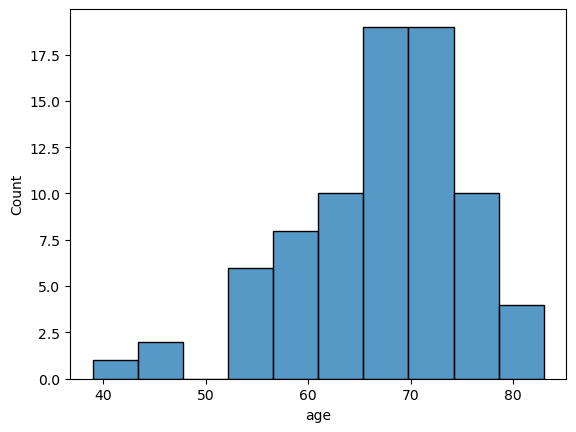

In [92]:
sns.histplot(data = patient_df_rel["age"])

The distributon of the patient age is skewed to the left, indicating that most patients are in the later decades of their lives. The distributions of other numerical data are visualized below. 

<Axes: xlabel='igg4', ylabel='Count'>

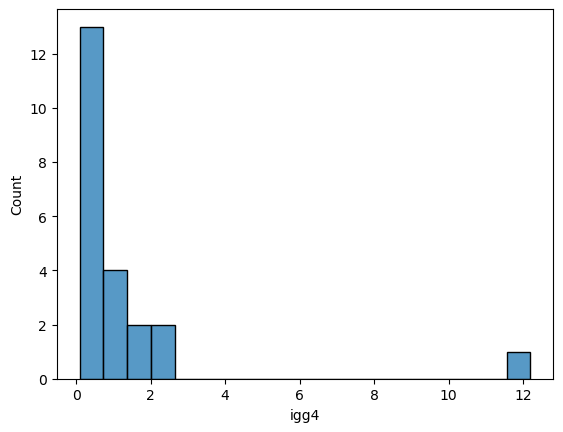

In [93]:
sns.histplot(data = patient_df_rel["igg4"])

<Axes: xlabel='diagroot', ylabel='Count'>

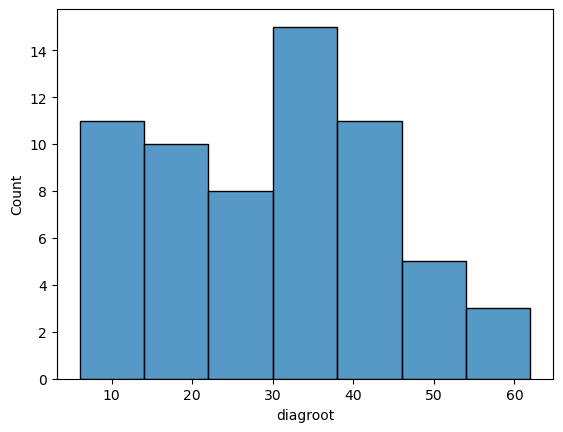

In [94]:
sns.histplot(data = patient_df_rel["diagroot"])

In [95]:
# print(patient_df_rel.describe())

In [96]:
patient_df_rel["geslacht"].value_counts()

1.0    41
2.0    38
Name: geslacht, dtype: int64

The dataset consists of 41 men and 39 women.

In [97]:
patient_df_rel["reggroep"].value_counts() 

1.0    77
2.0     2
Name: reggroep, dtype: int64

Most patients have suspected or proven tumor or premalignant cyst (makes sense, as IPMN is a premalignant cyst).

In [98]:
patient_df_rel["mri"].value_counts()

1.0    70
0.0     7
Name: mri, dtype: int64

There are 7 patients in this data set for which there are no registered MRI scans according to the DPCG. We have obtained the scans for all patients apart from those clearly indicated above.

In [99]:
patient_df_rel["beeldconcl"].value_counts() 

2.0    68
1.0     4
0.0     4
Name: beeldconcl, dtype: int64

For 4 of the patients, no tumor is visible in the scan. For another 4 patients, a solid tumor is visible. A cyst is present in 69 of the patient scans.

In [100]:
patient_df_rel["lokalisatie"].value_counts() 

1.0    41
2.0    16
3.0    13
4.0     1
Name: lokalisatie, dtype: int64

The tumor is found in the head of the pancreas for 42 of the patients, in the body for 16, and in the tail for 13 of the patients. One patient has a periampullary tumor. 

In [101]:
patient_df_rel["POPF"].value_counts() 

0.0    66
2.0     9
3.0     4
Name: POPF, dtype: int64

13 of the patients developed POPF. For 9 of those patients, the POPF was grade B, while for 4 patients, the POPF was classified as grade C.

In [162]:
patient_df_rel["ipmnpost"].value_counts() 

1.0    44
3.0    11
4.0     8
2.0     6
0.0     2
Name: ipmnpost, dtype: int64

No malignancy was found for 2 of the patients. 44 patients were diagnosed with a low-grade dysplasia, 6 with a medium-grade dysplasia, 11 with a high-grade dysplasia, and 8 with invasive carcinoma.

## MRI Attributes

Seven MRI attributes are reported for each patients. These include the slice thickness, rows, column, magnetic field strength, flip angle, pixel spacing, slice spacing, and the image position in three axes [x, y, z]. The x-axis is increasing to the left hand side of the patient. The y-axis is increasing to the posterior side of the patient. The z-axis is increasing toward the head of the patient.

The attributes were extracted using from the header of each DICOM file, the standard protocol used in medical imaging. The attributes for three patients are reported below. Reporting these attributes is crucial for accurate image interpretation, consistency and interoperability, and ensuring compliance with regulatory requirements.

In [163]:
mri_modalities = pd.read_csv(r"L:\basic\divi\jstoker\slicer_pdac\Master Students SS 23\Matej\Patient data\MRI_modalities_v2.csv")
mri_modalities = mri_modalities.drop(columns=["Unnamed: 0"]).set_index("Parameter")
mri_modalities_short = mri_modalities.iloc[:, :3]
# print(mri_modalities_short.to_markdown()) 

| Parameter               | PANC-1012                                             | PANC-1021                                              | PANC-1022                                            |
|:------------------------|:------------------------------------------------------|:-------------------------------------------------------|:-----------------------------------------------------|
| SliceThickness          | 6                                                     | 4,4                                                    | 6                                                    |
| Rows                    | 156                                                   | 192                                                    | 216                                                  |
| Columns                 | 192                                                   | 192                                                    | 268                                                  |
| Magnetic Field Strength | 1,5                                                   | 1,5                                                    | 1,5                                                  |
| Flip Angle              | 90                                                    | 10                                                     | 90                                                   |
| PixelSpacing            | [1.9791666269302, 1.9791666269302]                    | [1.953125, 1.953125]                                   | [1.567164182663, 1.567164182663]                     |
| SpacingBetweenSlices    | 7,2                                                   | 2,2                                                    | 7,2                                                  |
| ImagePositionPatient    | [-211.79176330566, -167.45005774498, 48.901161193848] | [-178.93571748660, -226.11171629297, -16.384918212890] | [-233.91821146011, -185.58309459686, 11.91090130806] |

# Appendix

It is necessary to go through each variable to get an understanding of what it represents. This will be done with the help of the variable dictionary from the DPCG.

Going through the variables, these ones seem the most relevant: 

* gebdat (geboorte datum) -> we know that patients are more likely to develop IPMN in the 6th and 7th decade in life // might need to transform this to "age" using "behperdat"
* geslacht -> women (?) are more affected than men 
    * 1 = men
    * 2 = women // might need to be changed into a binary variable
* reggroep
    * 1 = patient has suspected OR proven pancreatic/periampullary tumor or premalignant cyst
    * 2 = patient discussed in multidisciplinary consultation, no exploration and/or resection
    * 3 = chronic pancreatitis requiring pancreatic head or tail resection
* igg4
* beeldv or mri 
* beeldconcl -> is there a tumor visible in the scan? // maybe
    * 0 = no
    * 1 = yes, solid tumor
    * 2 = yes, cyst
* lokalisatie
    * 1 = head of the pancreas
    * 2 = body of the pancreas
    * 3 = tail of the pancreas 
    * 4 = periampullary 
    * 5 = duodenum
    * 9 = unknown 
* diagroot
* bildrain
* draindat
* cytdiagnose
    * 1 = benign 
    * 2 = atypical or suspected of malignancy
    * 3 = malignant 
    * 4 = not judgeable 
* ASA score // maybe, but I don't see this going too far
* resectie // just to confirm that all patients underwent pancreatic resection 
* laparoscopie // maybe, not sure whether this would have an impact on fistulae 
    * 0 = no
    * 1 = yes
    * 9 = unknown
* invasief 
    * 1 = no
    * 2 = yes; laparoscopy with conversion
    * 3 = yes; laparoscopy without conversion
    * 4 = yes; robot-assisted with conversion
    * 5 = yes; robot-assisted without conversion
    * 9 = unknown 
* typok
    * 1 = PPPD 
    * 2 = classic Whipple
    * 10 = PRPD
    * 3 = resection of pancreatic body or tail 
    * 4 = central pancreatic resection 
    * 5 = total pancreatectomy 
    * 6 = pancreatic tumor enucleation 
    * 7 = total duodenectomy 
    * 77 = other
    * 99 = unknown
* Check variables under Chirurgie: Aanvullende resecties and determine whether relevant 
* aspect
    * 1 = normal / soft
    * 2 = hard / fibriotic
    * 9 = unknown
* fistel2016 // important: data not available for all patients 
    * 0 = no
    * 1 = Biochemical leak: no clinical consequences
    * 2 = Grade B: persistent drainage > 3 weeks, clinically relevant change in management of POPF, ..., signs of infection due to organ failure
    * 3 = Grace C: Grade B + reoperation, prolonged hospital stay, ICU, death
* fistel 
    * 0 = no or Grade A (no therapeutic action needed, hospital stay not prolonged)
    * 1 = Grade B (medical action but no reoperation, prolonged hospital stay, possible discharge with drains in situ)
    * 2 = Grade C (re-operation and / or prolonged hospital care and/or IC-care and/or death)
* Variables in section Adjuvante behandeling
    * adjuvant 
        * 1 = no
        * 2 = chemoradiotherapy
        * 3 = chemotherapy 
        * 4 = radiotherapy 
        * 7 = other
        * 9 = unknown
    * neoadjuvant, adjuvantadv, ...
* ipmnpost
    * 0 = no malignancy
    * 1 = low-grade dysplasia
    * 2 = medium-grade dysplasia
    * 3 = high-grade dysplasia (carcinoma in situ)
    * 4 = invasive carcinoma 

In [164]:
variable_dictionary = {
    "gebdat": "date of birth",
    "geslacht": "sex",
    "behperdat": "start of treatment period",
    "reggroep": "reason for registration", 
    "verrichting-upn": "patient hospital number",
    "lengte": "height in cm",
    "gewicht": "preoperative weight in kg",
    "gewverlies": "weight loss in kg",
    "gewperiode": "period in which weight loss occurred in weeks",
    "ecog": "ECOG performance status; measuring how the patient's disease is progressing",
    "igg4": "IgG4 in g/L",
    "cea": "carcinoembryonic antigen in micrograms/L", 
    "ca199": "CA19.9 in kU/I", 
    "beeldv": "Is er een CT, MRI of MRCP verrich?",
    "mri": "Is er een MRI verricht?",
    "beeldconcl": "Is er op CT of MRi een tumor zichtbaar in het pancreas of periampullair?",
    "lokalisatie": "localization",
    "diagroot": "Largest diameter of the tumor, in the transverse plane in mm",
    "vaten": "Is there vessel involvment?",
    "bildrain": "Is there billary drainage?",
    "draindat": "date of last gallbladder drainage",
    "cytdiagnose": "cytological diagnosis",
    "ASA score": "subjective overall patient health score",
    "resectie": "resection condition (?)",
    "invasief": "Was the resection minimally invasive?",
    "typok": "type of resection",
    "resecveneus": "venous resection of portal vein and/or superior mesenteric vein and type of resection",
    "aspect": "aspect of the pancreas",
    "fistel": "POPF following ISGPS definition 2005",
    "fistel2016": "POPF following ISGPS definition 2016"
}